In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import (cross_val_score,
                                     GridSearchCV)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (make_scorer, 
                            accuracy_score, 
                            roc_auc_score, 
                            confusion_matrix, 
                            f1_score)

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

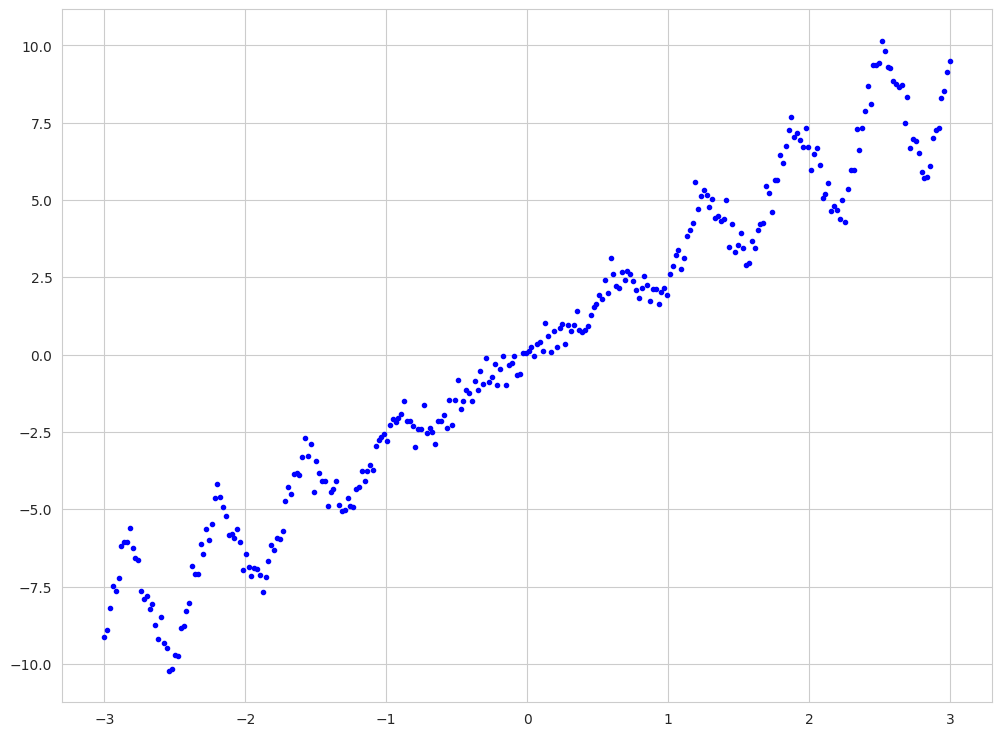

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [5]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

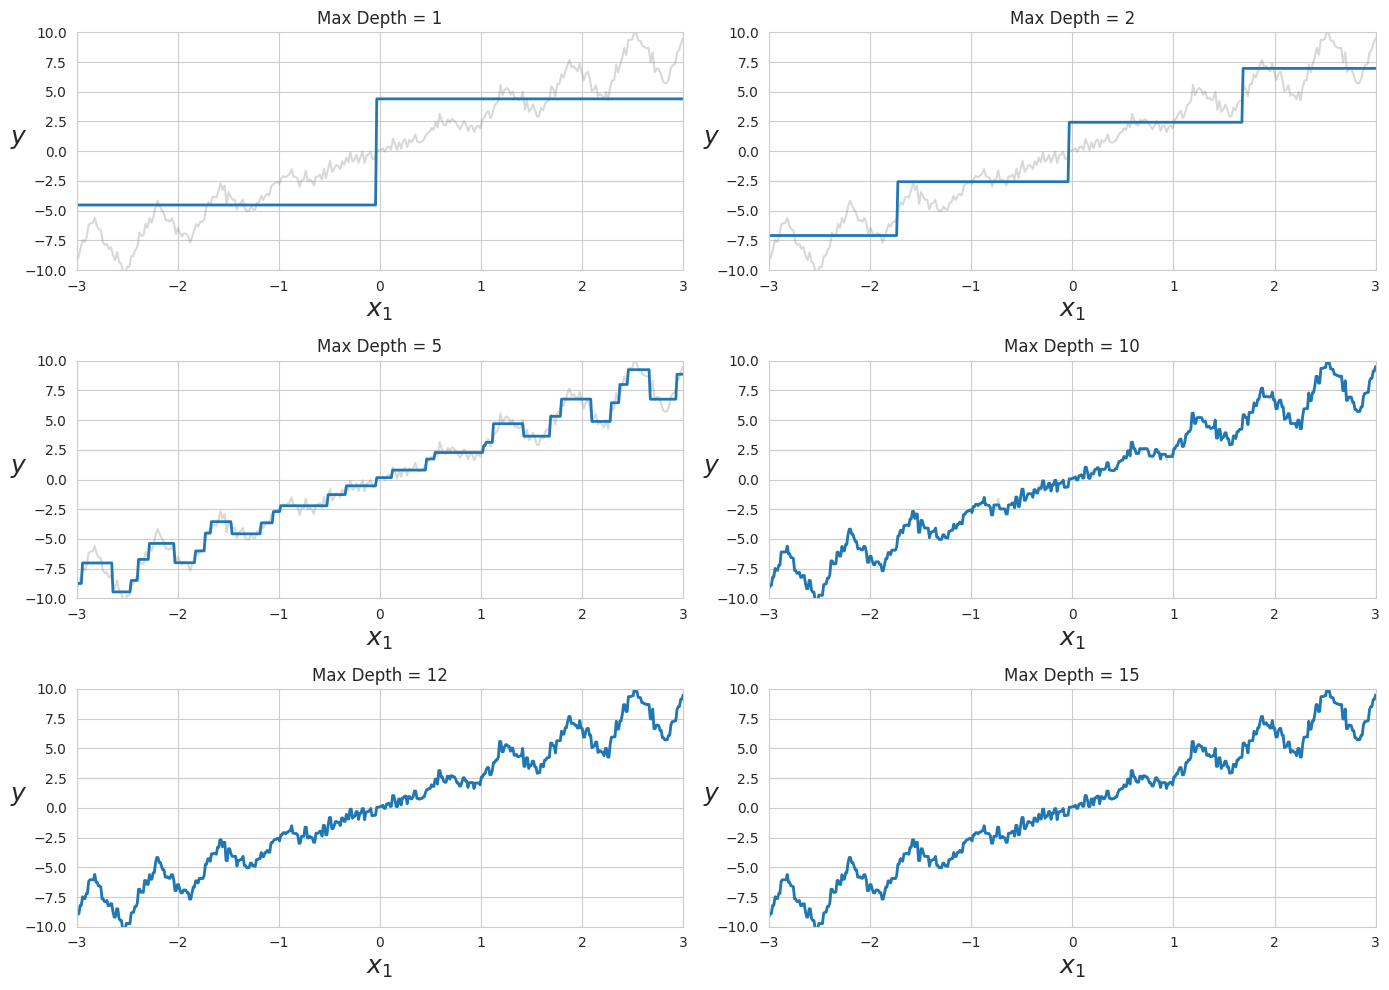

In [6]:
plt.figure(figsize=(14, 10))

max_depths = [1, 2, 5, 10, 12, 15]
for i, max_depth in enumerate(max_depths, 1):
    plt.subplot(3, 2, i)
    plt.title(f"Max Depth = {max_depth}")
    
    # Фоновый график
    plt.plot(X.reshape(-1), y.reshape(-1), "gray", alpha=0.3)
    
    tree_reg = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    tree_reg.fit(X, y)
    plot_regression_predictions(tree_reg, X, y)

plt.tight_layout()
plt.show()

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [7]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

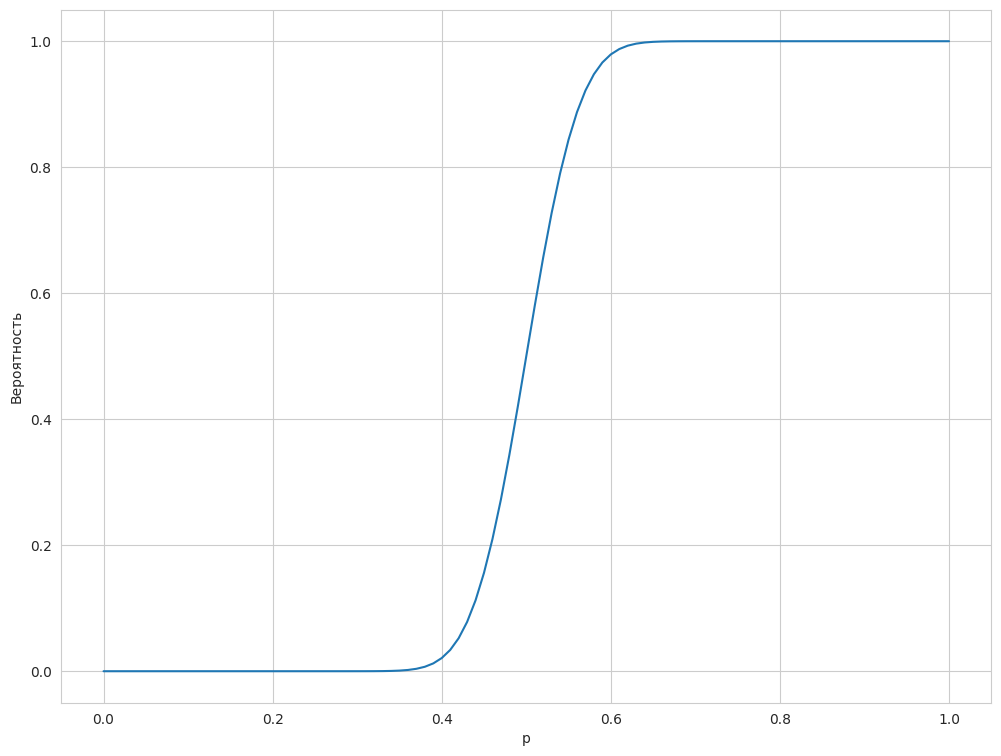

In [8]:
p_values = np.linspace(0, 1, 101)

accuracy_probabilities = 0
for i in range(51, 102):
    term = (np.power((1 - p_values), (101 - i)) * np.power(p_values, i) * math.factorial(101)) / (math.factorial(i) * math.factorial(101 - i))
    accuracy_probabilities += term

plt.plot(p_values, accuracy_probabilities)
plt.xlabel('p')
plt.ylabel('Вероятность')
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [9]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

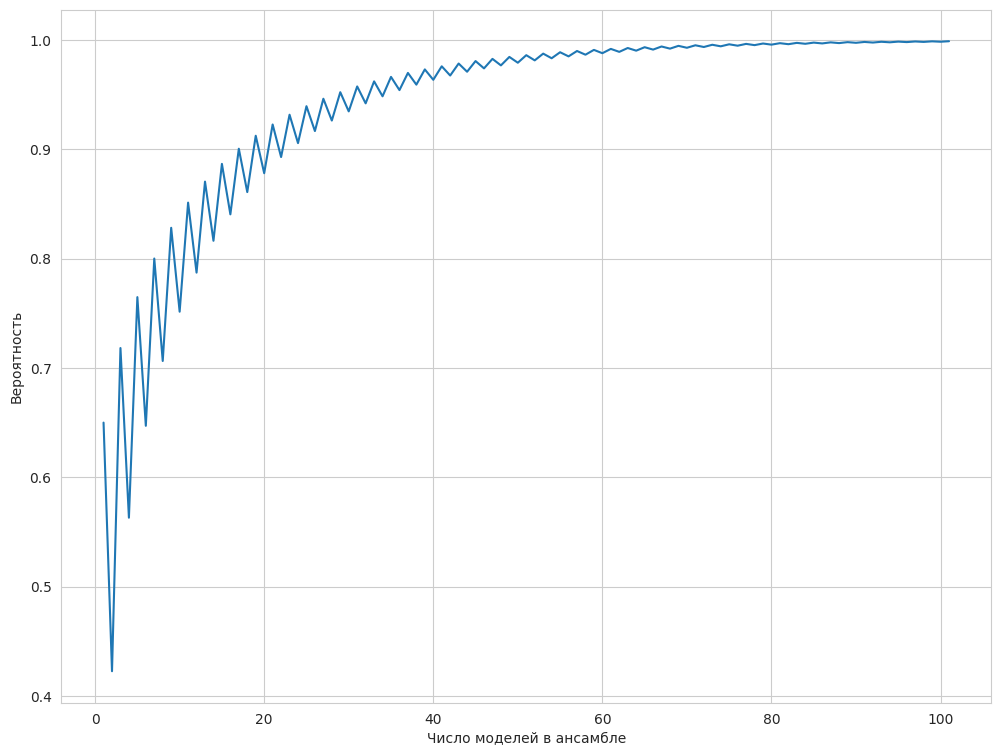

In [10]:
p = 0.65
n_models = np.arange(1, 102)

# зависимость вероятности правильной классификации от числа моделей в ансамбле
accuracy_probabilities = np.zeros_like(n_models, dtype=float)

# посчитаем вероятность для каждого числа моделей в ансамбле
for i, mdl in enumerate(n_models):
    for j in np.arange(mdl // 2 + 1, mdl + 1):
        accuracy_probabilities[i] += (np.power((1 - p), (mdl - j)) * np.power(p, j) * math.factorial(mdl)) / (math.factorial(j) * math.factorial(mdl - j))

plt.plot(n_models, accuracy_probabilities)
plt.xlabel('Число моделей в ансамбле')
plt.ylabel('Вероятность')
plt.show()

Опишите ваши наблюдения:

* Вероятность правильной классификации возрастает с увеличением значения p (логично, т.к. большее значение p = более точные предсказания от каждого классификатора); 
* Но при увеличении числа классификаторов в ансамбле в какой-то момент точность предсказания перестаёт возрастать и выходит на плато (в нашем случае с ±80 моделей).

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [11]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        n_samples, n_features = X.shape

        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)

            feat_ids = np.random.choice(n_features, self.max_features, replace=False)
            self.feat_ids_by_tree.append(feat_ids)

            sample_ids = np.random.choice(n_samples, n_samples, replace=True)

            tree = DecisionTreeClassifier(
                max_depth=self.max_depth, max_features=self.max_features
            )
            tree.fit(X[sample_ids][:, feat_ids], y[sample_ids])
            self.trees.append(tree)

        return self

    def predict_proba(self, X):
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        probas = np.zeros((X.shape[0], len(self.classes_)))

        for feat_ids, tree in zip(self.feat_ids_by_tree, self.trees):
            tree_probas = tree.predict_proba(X[:, feat_ids])
            probas += tree_probas

        probas /= self.n_estimators

        return probas
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [12]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

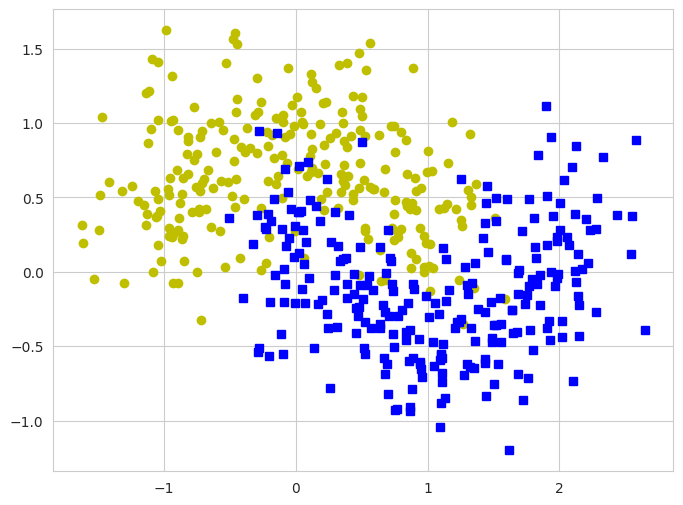

In [13]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [14]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

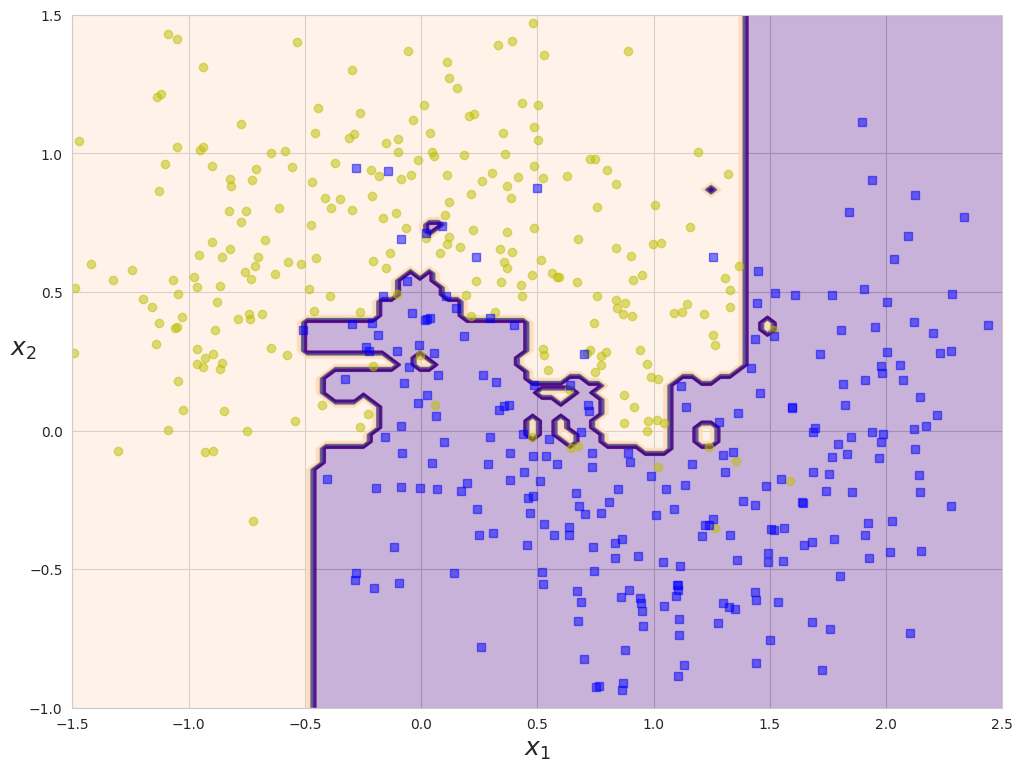

In [15]:
rf_example = RandomForestClassifierCustom(n_estimators=100, max_depth=20, max_features=2)
rf_example.fit(X, y)
plot_decision_boundary(rf_example, X, y)

In [16]:
# я вижу крокодила на графике, а вы?

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [17]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

In [19]:
# подибраем параметры
param_grid = {
    'n_estimators': [5, 10, 15, 20, 25, 30],
    'max_depth': [None, 2, 5, 7, 10, 12, 15],
    'max_features': [1, 2, 3]
}

In [20]:
rf_model = RandomForestClassifierCustom()

In [21]:
scoring = {'accuracy': make_scorer(accuracy_score), 'roc_auc': make_scorer(roc_auc_score)}

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring=scoring, refit='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifierCustom(),
             param_grid={'max_depth': [None, 2, 5, 7, 10, 12, 15],
                         'max_features': [1, 2, 3],
                         'n_estimators': [5, 10, 15, 20, 25, 30]},
             refit='roc_auc',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'roc_auc': make_scorer(roc_auc_score, response_method='predict')})

In [22]:
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшее значение accuracy:", accuracy_score(y_test, grid_search.predict(X_test)))
print("Лучшее значение ROC AUC:", roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1]))

Лучшие параметры: {'max_depth': 10, 'max_features': 2, 'n_estimators': 25}
Лучшее значение accuracy: 0.912
Лучшее значение ROC AUC: 0.9653846153846153


In [23]:
# судя по метрикам, должен выйти приемлемый результат

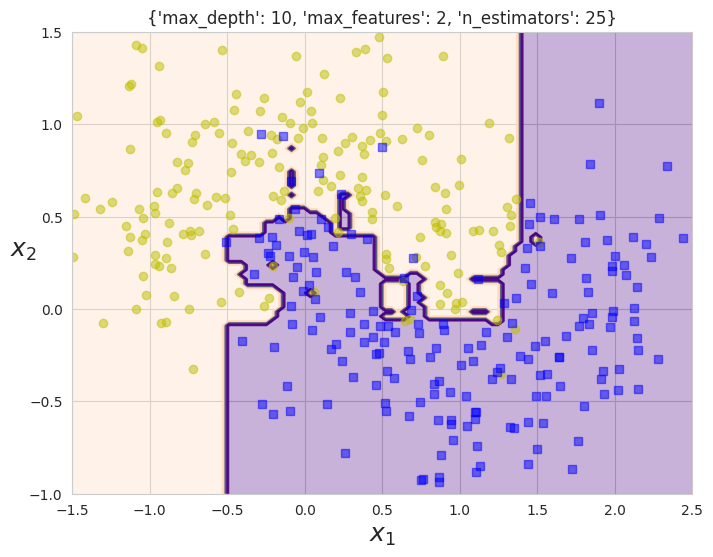

In [24]:
# получаем лучшую по параметрам модель
best_rf_model = grid_search.best_estimator_

plt.figure(figsize=(8, 6))
plot_decision_boundary(best_rf_model, X_train, y_train)
plt.title(grid_search.best_params_)
plt.show()

Кажется, что стало лучше.

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [25]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [26]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [27]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [28]:
# количество признаков в датасете
X.shape[1]

30

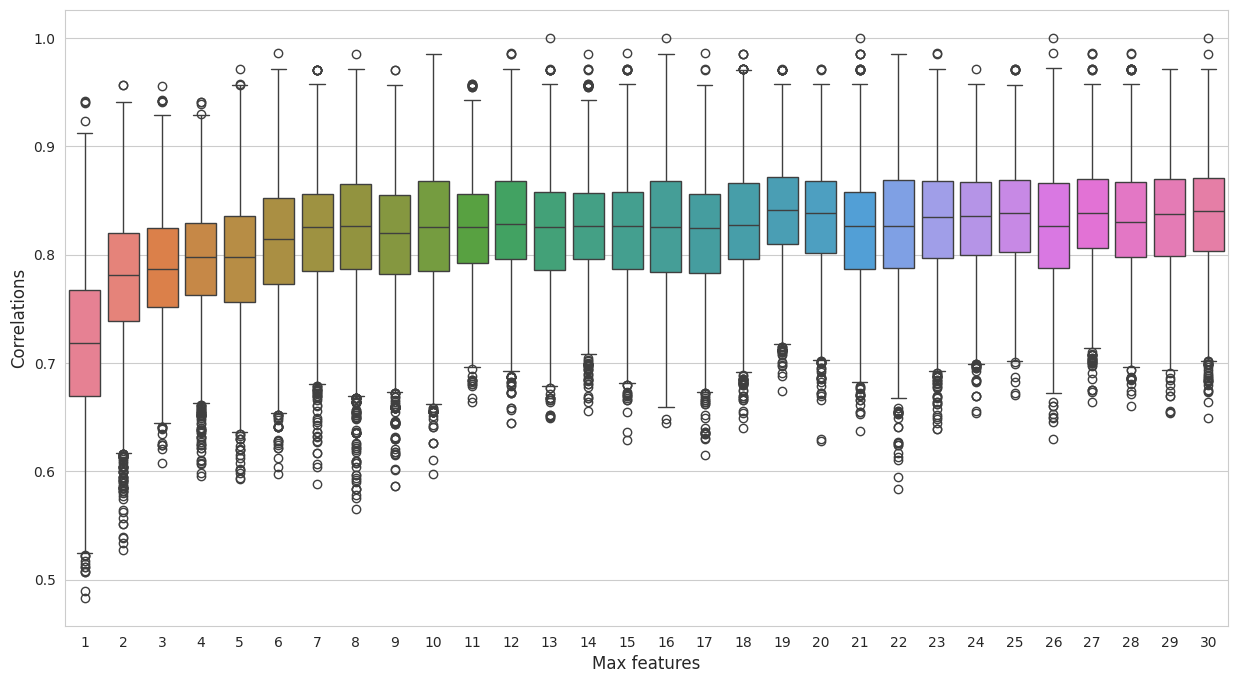

In [29]:
corr_coeffs = []

# от 1 до числа признаков
for features in range(1, 31):
    clf = RandomForestClassifier(max_features=features)
    clf.fit(X_train, y_train)
    corr_coeffs.append(base_model_pair_correlation(clf, X_test))

data = pd.DataFrame(np.array(corr_coeffs).T, columns=range(1, 31))

plt.figure(figsize=(15, 8))
sns.boxplot(data=data)
plt.xlabel('Max features', size=12)
plt.ylabel('Correlations', size=12)
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [30]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

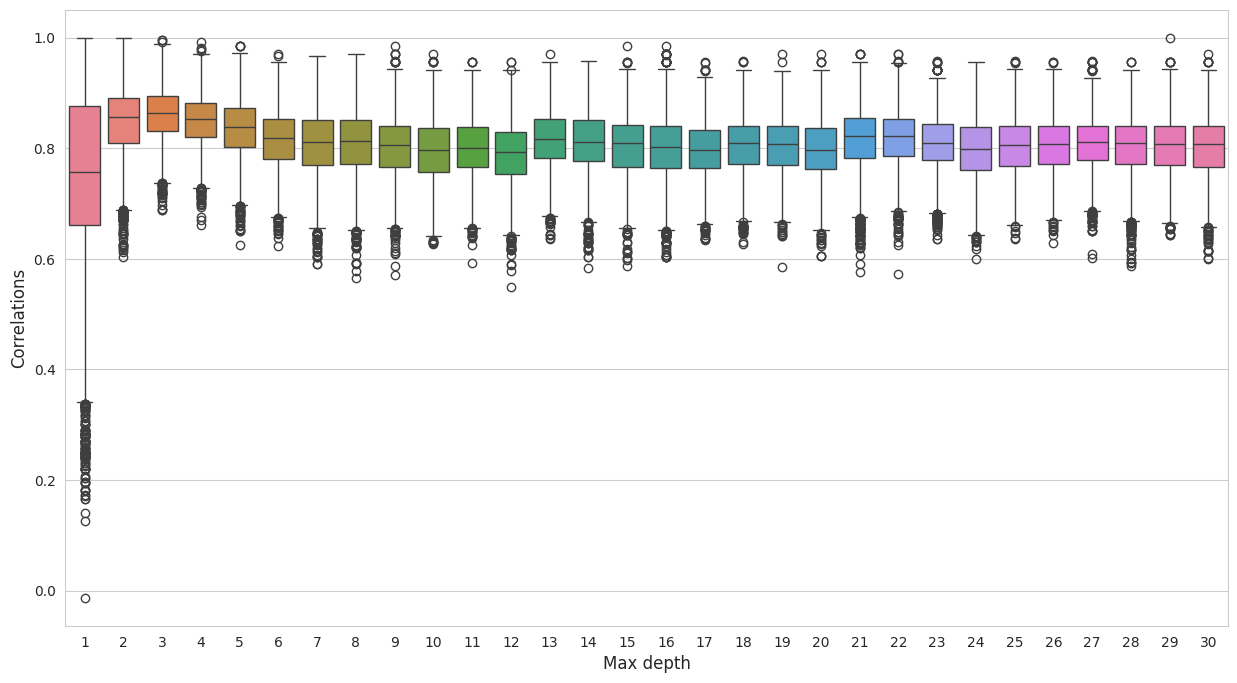

In [31]:
corr_coeffs = []

# от 1 до числа признаков
for depth in range(1, 31):
    clf = RandomForestClassifier(max_depth=depth)
    clf.fit(X_train, y_train)
    corr_coeffs.append(base_model_pair_correlation(clf, X_test))

data = pd.DataFrame(np.array(corr_coeffs).T, columns=range(1, 31))

plt.figure(figsize=(15, 8))
sns.boxplot(data=data)
plt.xlabel('Max depth', size=12)
plt.ylabel('Correlations', size=12)
plt.show()

Опишите ваши наблюдения:

* При увеличении значения `max_features` корреляция возрастает, однако при достижении порога примерно в 7-8 она выходит на плато.
* Схожая ситуация с `max_depth`: сначала корреляция возрастает, после 3 начинается снижаться и где-то с 6-7 выравнивается и снова получается плато.
* При малых значениях как `max_features`, так и `max_depth` разброс признака оочень большой.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [32]:
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
# heart_dataset = pd.read_csv("heart.csv")
heart_dataset = pd.read_csv("../data_folder/raw_data/heart.csv")

/bin/bash: gdown: команда не найдена


In [33]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [34]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(verbosity=-1, random_state=SEED)  # добавила verbosity=-1, т.к. без него вылезало несколько сотен(!) предупреждений
lgbm_rf = lightgbm.LGBMClassifier(verbosity=-1, boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [35]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(base_models, voting='hard') # хотя hard и так по дефолту
voting_soft = VotingClassifier(base_models, voting='soft')

## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.8281746031746032
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
LGBMClassifier: 0.817010631644778
XGBRFClassifier: 0.8499478840942256
LGBMClassifier: 0.8132478632478634
LogisticRegression: 0.8500073681108163
GaussianNB: 0.8140676625250128
VotingClassifier: 0.8494440278941667
VotingClassifier: 0.8455110375195781


Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [36]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [37]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [38]:
# будем смотреть корреляции на soft
# т.к. при первичном просмотре обоих типов голосования для soft получались более высокие значения f1, чем для hard

voting_soft.fit(X_train, y_train)
corr_soft = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)

for est1, est2, corr in corr_soft:
    print(f"{est1.__class__.__name__} vs {est2.__class__.__name__}: {corr}")

DecisionTreeClassifier vs RandomForestClassifier: 0.8134894007824364
DecisionTreeClassifier vs ExtraTreesClassifier: 0.7749544834941163
DecisionTreeClassifier vs KNeighborsClassifier: 0.31332949662835446
DecisionTreeClassifier vs SVC: 0.715376472596946
DecisionTreeClassifier vs SVC: 0.2820135356695378
DecisionTreeClassifier vs CatBoostClassifier: 0.7875690140798687
DecisionTreeClassifier vs LGBMClassifier: 0.8282760696670941
DecisionTreeClassifier vs LGBMClassifier: 0.8612656428887722
DecisionTreeClassifier vs XGBClassifier: 0.8088299404726914
DecisionTreeClassifier vs XGBRFClassifier: 0.891292732793176
DecisionTreeClassifier vs LogisticRegression: 0.7399817403132603
DecisionTreeClassifier vs GaussianNB: 0.6827714012201818
RandomForestClassifier vs ExtraTreesClassifier: 0.9215651183028867
RandomForestClassifier vs KNeighborsClassifier: 0.3924167426564557
RandomForestClassifier vs SVC: 0.8263983680718642
RandomForestClassifier vs SVC: 0.4055273375196602
RandomForestClassifier vs CatBoos

In [39]:
# base_models_new = [("DT", dt), ("RF", rf), 
#                ("ETC", etc), ("KNN", knn), 
#                ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
#                ("CAT", cat), ("LGBM", lgbm), 
#                ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
#                ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

base_models_new = [("DT", dt), ("ETC", etc),
               ("XGB_RF", xgb_rf), ("NB", nb)]

voting_soft_new = VotingClassifier(estimators=base_models_new, voting='soft')
voting_soft_new.fit(X_train, y_train)

scores_new = cross_val_score(voting_soft_new, X_train, y_train, cv=3, scoring="f1")
print(f"{voting_soft_new.__class__.__name__}: {scores_new.mean()}")

# ну почти...

VotingClassifier: 0.869518302710989


In [40]:
# base_models_new = [("DT", dt), ("ETC", etc), ("CAT", cat),
#                ("XGB_RF", xgb_rf), ("NB", nb)]
# 0.869518302710989


# base_models_new = [("DT", dt), ("SVC_LIN", svc_lin), ("CAT", cat),
#                ("XGB_RF", xgb_rf), ("NB", nb)]
# 0.8668502028935633


# base_models_new = [("DT", dt), ("ETC", etc),("SVC_LIN", svc_lin),
#                ("XGB_RF", xgb_rf), ("NB", nb)]
# 0.8659318048206938


# base_models_new = [("DT", dt), ("SVC_LIN", svc_lin),
#                ("CAT", cat), ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]
# 0.8639104220499569


# base_models_new = [("DT", dt), ("ETC", etc), ("SVC_LIN", svc_lin),
#                ("CAT", cat), ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]
# 0.8627572016460906

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [41]:
# data = pd.read_csv("churn.csv")
data = pd.read_csv("../data_folder/raw_data/churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [42]:
# заменим значения на более информативные
data.replace({"yes": 1, "no": 0, "True.": 1, "False.": 0}, inplace=True)

In [43]:
data.shape

(3333, 21)

In [44]:
data.isna().sum()

State             0
Account Length    0
Area Code         0
Phone             0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   int64  
 5   VMail Plan      3333 non-null   int64  
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [46]:
data.describe()

,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,0.096910,0.276628,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.144914
std,39.822106,42.371290,0.295879,0.447398,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.352067
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,0.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000
50%,101.000000,415.000000,0.000000,0.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000
75%,127.000000,510.000000,0.000000,1.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000
max,243.000000,510.000000,1.000000,1.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


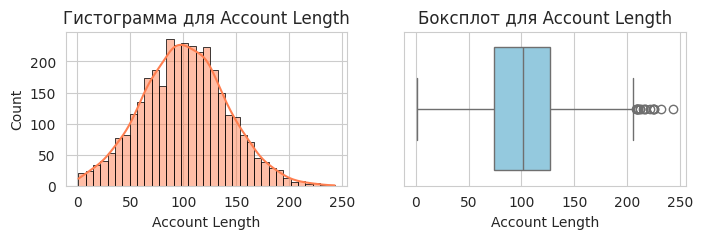

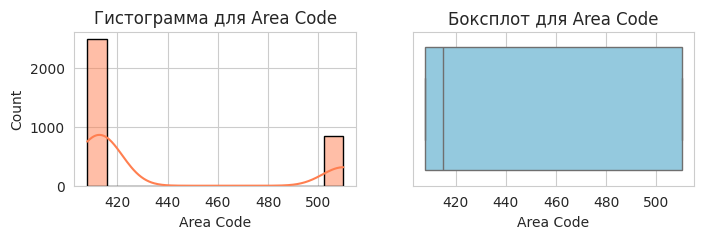

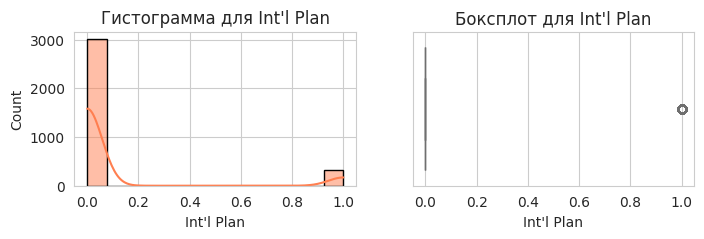

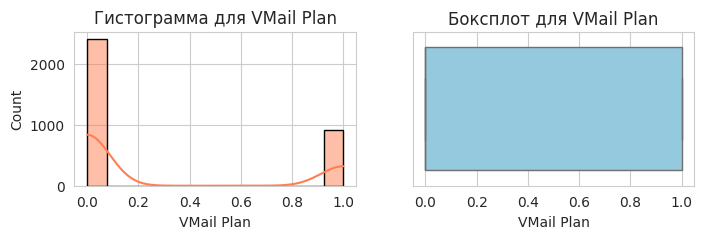

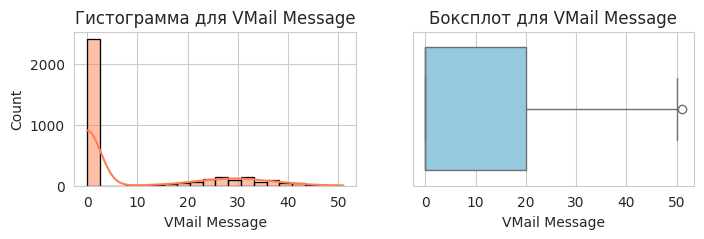

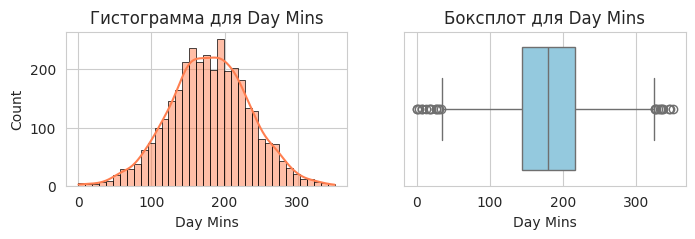

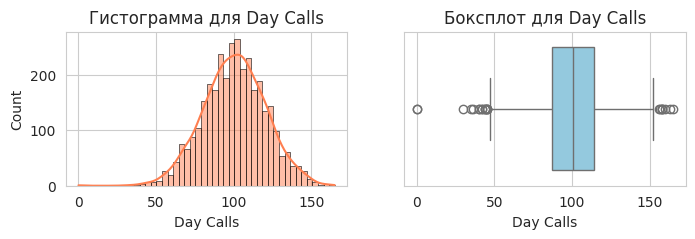

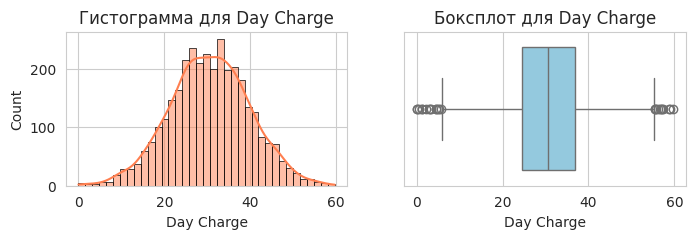

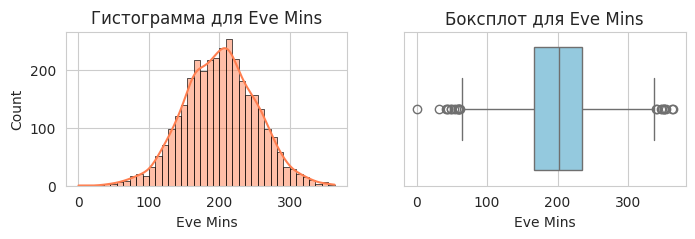

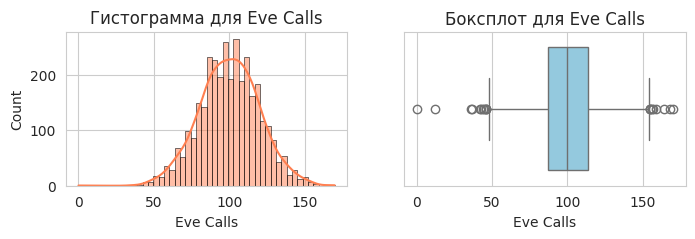

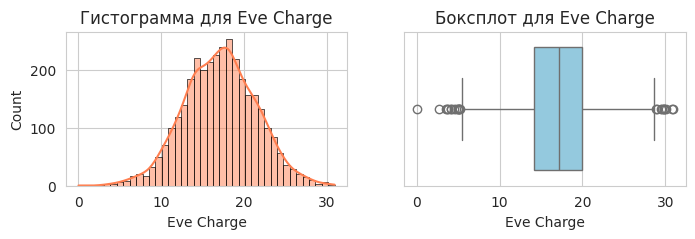

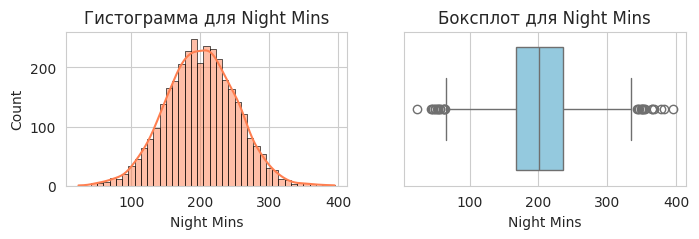

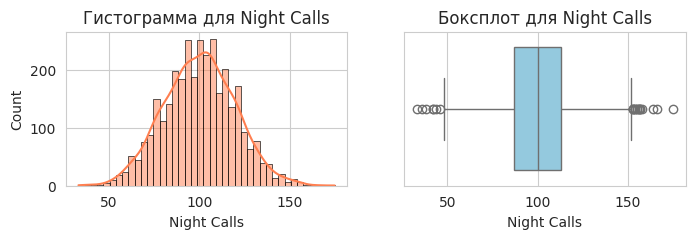

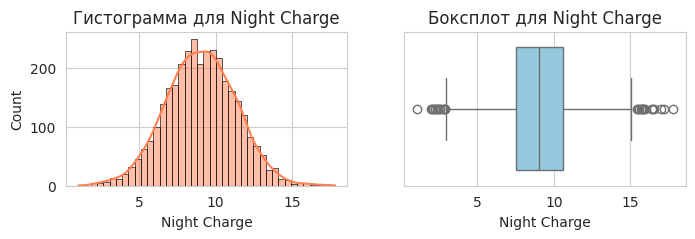

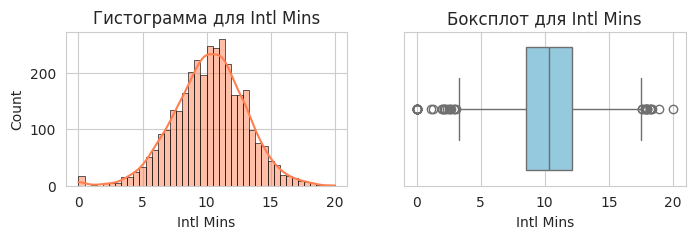

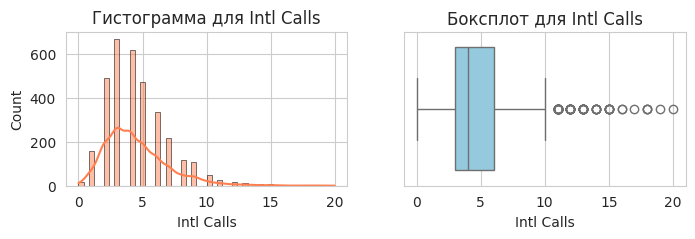

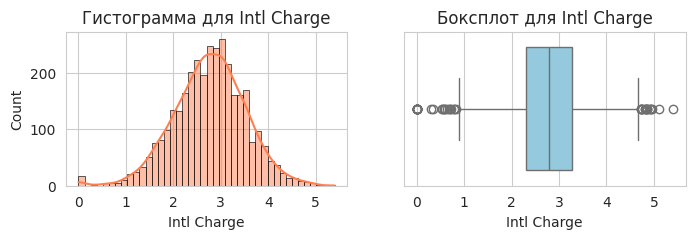

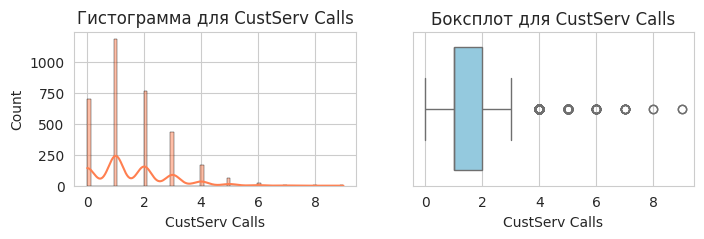

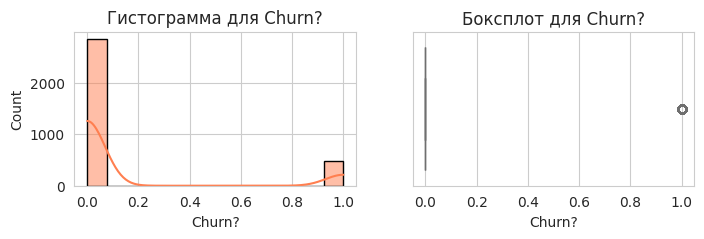

In [47]:
numeric_features = data.select_dtypes(include=['int64', 'float64'])

for column in numeric_features.columns:
    plt.figure(figsize=(8, 2))
    plt.subplot(1, 2, 1)
    sns.histplot(data[column], kde=True, color='coral', edgecolor='black')
    plt.title(f'Гистограмма для {column}')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[column], color='skyblue')
    plt.title(f'Боксплот для {column}')

    plt.show()

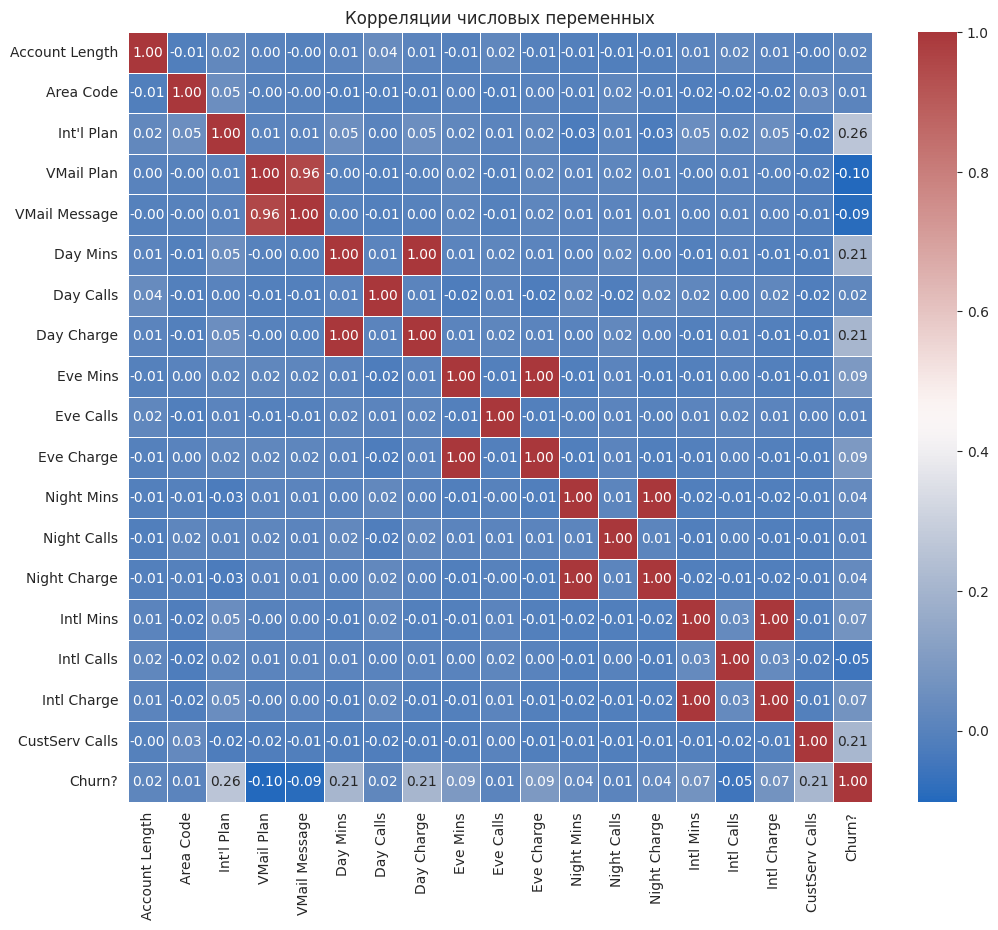

In [48]:
correlation_matrix = numeric_features.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='vlag', linewidths=0.5, fmt=".2f")
plt.title('Корреляции числовых переменных')
plt.show()

In [49]:
# уберем колонки, которые, на мой взгляд, не несут пользы для предсказаний, а также те что с сильной корреляцией
data_clean = data.drop(["State", "Area Code", "Phone", "VMail Plan", "Day Mins", "Eve Mins", "Night Mins", "Intl Mins"], axis=1)

In [50]:
X = data_clean.drop(['Churn?'], axis = 1)
y = data["Churn?"]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3,
                                                    random_state=SEED)

In [52]:
X.head()

,Account Length,Int'l Plan,VMail Message,Day Calls,Day Charge,Eve Calls,Eve Charge,Night Calls,Night Charge,Intl Calls,Intl Charge,CustServ Calls
0,128,0,25,110,45.07,99,16.78,91,11.01,3,2.70,1
1,107,0,26,123,27.47,103,16.62,103,11.45,3,3.70,1
2,137,0,0,114,41.38,110,10.30,104,7.32,5,3.29,0
3,84,1,0,71,50.90,88,5.26,89,8.86,7,1.78,2
4,75,1,0,113,28.34,122,12.61,121,8.41,3,2.73,3


In [53]:
X.columns

Index(['Account Length', 'Int'l Plan', 'VMail Message', 'Day Calls',
       'Day Charge', 'Eve Calls', 'Eve Charge', 'Night Calls', 'Night Charge',
       'Intl Calls', 'Intl Charge', 'CustServ Calls'],
      dtype='object')

In [54]:
cat_features = ["Int'l Plan"]  # и так булевое, можно отдельно не преобразовывать

num_features = ["Account Length", "VMail Message", "Day Calls",
               "Day Charge", "Eve Calls", "Eve Charge", "Night Calls", 
                "Night Charge", "Intl Calls", "Intl Charge", "CustServ Calls"]

In [55]:
# стандартизуем данные
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Я не подружилась с lightgbm: он на любые попытки предсказания выдаёт сотни, а то и тысячи строк с предупреждениями, причём они просто дублируют друг друга по многу раз. Так что сосредоточимся на xgboost и catboost.

### Случайный лес от xgboost

In [56]:
from xgboost import XGBRFClassifier

In [57]:
param_grid_xgbrf = {
    'subsample': [0.3, 0.5, 0.7, 0.9],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'n_estimators': [10, 50, 100, 200],
}

In [58]:
xgbrf_model = XGBRFClassifier()

In [59]:
# подбираем лучшие параметры
grid_search_xgbrf = GridSearchCV(estimator=xgbrf_model, param_grid=param_grid_xgbrf, cv=3)
grid_search_xgbrf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRFClassifier(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bytree=None, device=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       max_bin=None, max_cat_threshold=None,
                                       max...
                                       max_delta_step=None, max_depth=None,
                                       max_leaves=None, min_child_weight=None,
                                       missing=nan, monotone_constraints=None,
                                       multi_strategy=None, n_estimators=None,
                                       n_jobs=None, num_parallel_tree=None,
                                       objective='binary:logistic',
                                       random_state=None, reg_alpha=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.5],
                         'max_depth': [2, 4, 6, 8],
                         'n_estimators': [10, 50, 100, 200],
                         'subsample': [0.3, 0.5, 0.7, 0.9]})

In [60]:
print("Лучшие параметры случайного леса от xgboost:", grid_search_xgbrf.best_params_)

Лучшие параметры случайного леса от xgboost: {'learning_rate': 0.5, 'max_depth': 8, 'n_estimators': 50, 'subsample': 0.9}


In [61]:
# получаем лучшую модель из GridSearchCV
best_xgbrf_model = grid_search_xgbrf.best_estimator_

In [62]:
# предсказываем на тестовом наборе данных
y_pred_xgbrf = best_xgbrf_model.predict(X_test)

Accuracy: 0.941


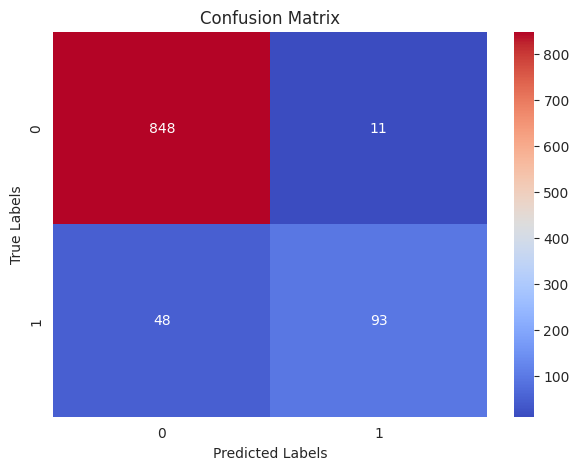

In [63]:
# оцениваем качество и выводим результаты
accuracy_xgbrf = accuracy_score(y_test, y_pred_xgbrf)
conf_matrix_xgbrf = confusion_matrix(y_test, y_pred_xgbrf)

print("Accuracy:", accuracy_xgbrf)

plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix_xgbrf, annot=True, fmt="d", cmap="coolwarm", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### Случайный лес от lightgbm

In [64]:
from lightgbm import LGBMClassifier

In [65]:
param_grid_lgbrf = {
    'bagging_fraction': [0.5, 0.7, 0.9],
    'feature_fraction': [0.5, 0.7, 0.9],
    'bagging_freq': [1, 5, 10]
}

In [66]:
lgbrf_model = LGBMClassifier(verbosity=-1, boosting_type="rf")

In [67]:
grid_search_lgbrf = GridSearchCV(estimator=lgbrf_model, param_grid=param_grid_lgbrf, scoring='f1', cv=3)
grid_search_lgbrf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LGBMClassifier(boosting_type='rf', verbosity=-1),
             param_grid={'bagging_fraction': [0.5, 0.7, 0.9],
                         'bagging_freq': [1, 5, 10],
                         'feature_fraction': [0.5, 0.7, 0.9]},
             scoring='f1')

In [68]:
print("Лучшие параметры случайного леса от lightgbm:", grid_search_lgbrf.best_params_)

Лучшие параметры случайного леса от lightgbm: {'bagging_fraction': 0.9, 'bagging_freq': 10, 'feature_fraction': 0.7}


In [69]:
best_lgbrf_model = grid_search_lgbrf.best_estimator_

In [70]:
y_pred_lgbrf = best_lgbrf_model.predict(X_test)

Accuracy: 0.93


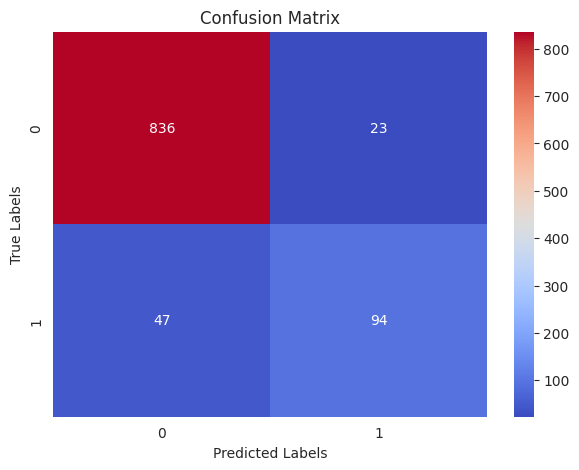

In [71]:
accuracy_lgbrf = accuracy_score(y_test, y_pred_lgbrf)
conf_matrix_lgbrf = confusion_matrix(y_test, y_pred_lgbrf)

print("Accuracy:", accuracy_lgbrf)

plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix_lgbrf, annot=True, fmt="d", cmap="coolwarm", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### Бустинг от xgboost

In [72]:
from xgboost import XGBClassifier

In [73]:
xgb_model = XGBClassifier()

In [74]:
param_grid_xgb = {
    'learning_rate': [0.1, 0.2, 0.5, 0.7],
    'n_estimators': [20, 30, 50, 70],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0]
}

In [75]:
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=3)
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.5, 0.7],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [20, 30, 50, 70],
                         'subsample': [0.8, 0.9, 1.0]})

In [76]:
print("Лучшие параметры бустинга от xgboost:", grid_search_xgb.best_params_)

Лучшие параметры бустинга от xgboost: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 30, 'subsample': 0.8}


In [77]:
best_xgb_model = grid_search_xgb.best_estimator_

In [78]:
y_pred_xgb = best_xgb_model.predict(X_test)

Accuracy: 0.955


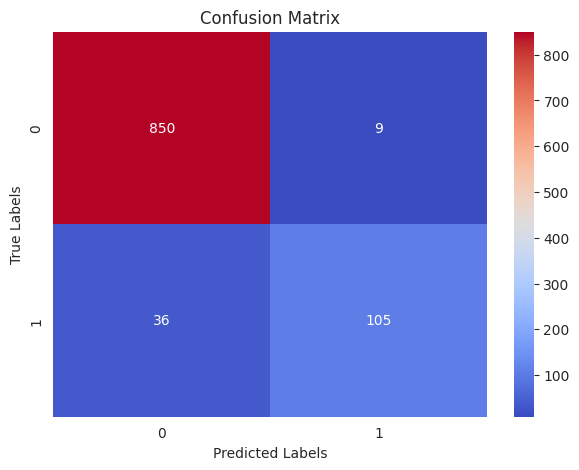

In [79]:
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print("Accuracy:", accuracy_xgb)

plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="coolwarm", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### Бустинг от lightgbm

In [80]:
from lightgbm import LGBMClassifier

In [81]:
lgb_model = LGBMClassifier(verbosity=-1)

In [82]:
param_grid_lgb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 10],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [83]:
grid_search_lgb = GridSearchCV(estimator=lgb_model, param_grid=param_grid_lgb, cv=3)
grid_search_lgb.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LGBMClassifier(verbosity=-1),
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [5, 7, 10],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 0.9, 1.0]})

In [84]:
print("Лучшие параметры бустинга от lightgbm:", grid_search_lgb.best_params_)

Лучшие параметры бустинга от lightgbm: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}


In [85]:
y_pred_lgb = grid_search_lgb.predict(X_test)

Accuracy: 0.951


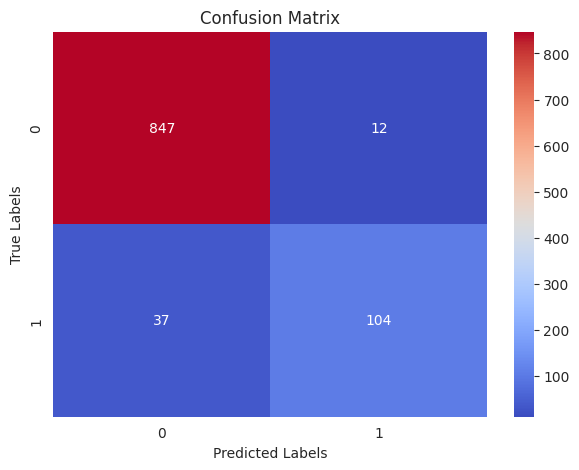

In [86]:
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
conf_matrix_lgb = confusion_matrix(y_test, y_pred_lgb)

print("Accuracy:", accuracy_lgb)

plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix_lgb, annot=True, fmt="d", cmap="coolwarm", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Итого все модели показали плюс-минус схожее качество, если полагаться на значения метрик.  
На CatBoost, при всей любви к этому загадочному названию, меня не хватило.

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [87]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

<img src="https://i.postimg.cc/GtbrBQzQ/photo-2024-03-10-22-48-20.jpg" width="600" height="380">

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Похоже, я уже преисполнилась и просто ищу покоя, умиротворения и гармонии от слияния с бесконечно вечным. Поэтому эта домашка, хоть и была для меня очень сложной, морально далась легче, чем первая. Разве что больше ощутился объём, + очень много времени ушло на гугл и перебор комбинаций моделей для допзадания.